# <p style="background-color:#000080; font-family:calibri; color:white; padding-top: 30px; padding-bottom: 30px;font-size:100%; text-align:center; border-radius:15px 50px;"> E-commerce Product Delivery Prediction </p>


# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 1 | Import Libraries</p>


In [452]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from common_function import common_functions,train_and_evaluate_multiple_models
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump
from sklearn.preprocessing import StandardScaler

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 2 | Load Data And Read Data </p>


In [453]:
data = pd.read_csv("E_Commerce.csv")
common_fun = common_functions()

In [454]:
data.duplicated().value_counts()

False    10999
Name: count, dtype: int64

In [455]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [456]:
data.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [457]:
data = data.drop(columns=['ID'])

In [458]:
data['Reached.on.Time_Y.N'].value_counts().unique()

array([6563, 4436], dtype=int64)

<h3 style="color:#ADD8E6;">Step 2-1: Cost-to-Weight Ratio: Evaluating Product Value per Unit Weight </h3>


In [459]:
data['Cost_to_Weight_Ratio'] = data['Cost_of_the_Product'] / data['Weight_in_gms']

<h3 style="color:#ADD8E6;">Step 2-2: Prior Purchases and Discount Offered </h3>


In [460]:
data['PriorPurchases_DiscountInteraction'] = data['Prior_purchases'] * data['Discount_offered']

<h3 style="color:#ADD8E6;">Step 2-3: Customer Care Calls and Customer Rating </h3>


In [461]:
data['Calls_Rating_Interaction'] = data['Customer_care_calls'] * data['Customer_rating']

<h3 style="color:#ADD8E6;">Step 2-4: Proportion of Discount Relative to Product Cost </h3>


In [462]:
data['Discount_Percentage'] = (data['Discount_offered'] / data['Cost_of_the_Product']) * 100

<h3 style="color:#ADD8E6;">Step 2-5: Creating a High Discount Indicator Feature </h3>


In [463]:
data['High_Discount'] = (data['Discount_offered'] > 20).astype(int)

In [464]:
# discount_avg = data.groupby('Reached.on.Time_Y.N')['Discount_offered'].mean()
# data['Avg_Discount_OnTime'] = data['Reached.on.Time_Y.N'].map(discount_avg)

<h3 style="color:#ADD8E6;">Step 2-6: Target Encoding for Mode of Shipment </h3>


In [465]:
mean_target = data.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean()
data['Mode_of_Shipment_encoded'] = data['Mode_of_Shipment'].map(mean_target)

<h3 style="color:#ADD8E6;">Step 2-7: Handling Missing Values: Median for Cost and Mode for Shipment </h3>


In [466]:
data['Cost_of_the_Product'].fillna(data['Cost_of_the_Product'].median(), inplace=True)
data['Mode_of_Shipment'].fillna(data['Mode_of_Shipment'].mode()[0], inplace=True)

C:\Users\jay\AppData\Local\Temp\ipykernel_10300\1889279601.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Cost_of_the_Product'].fillna(data['Cost_of_the_Product'].median(), inplace=True)
C:\Users\jay\AppData\Local\Temp\ipykernel_10300\1889279601.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [467]:
scaler = StandardScaler()
numerical_features = ['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms', 'Prior_purchases']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 3 | Get Correlation of "Churn" with other variables </p>


<h3 style="color:#ADD8E6;">Step 3-1: Gender Distribution </h3>


Text(0.5, 1.0, 'Gender Distribution')

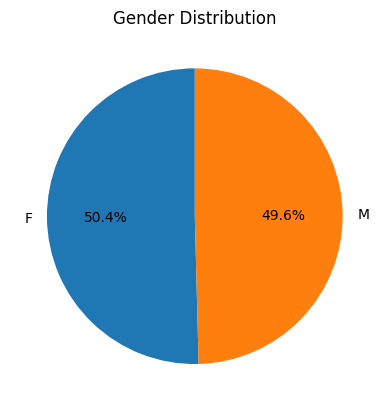

In [468]:
plt.pie(data['Gender'].value_counts(),labels = ['F','M'], autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')

<h3 style="color:#ADD8E6;">Step 3-2: Exploratory Data Analysis of Product Features </h3>


Text(0.5, 1.0, 'Cost of the Product')

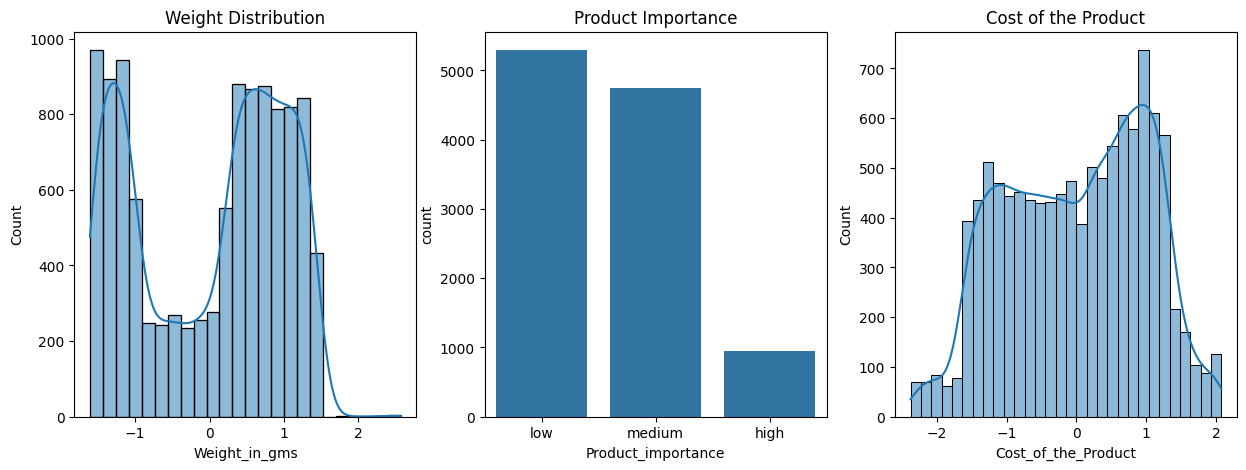

In [469]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(data['Weight_in_gms'], ax=ax[0], kde=True).set_title('Weight Distribution')
sns.countplot(x = 'Product_importance', data = data, ax=ax[1]).set_title('Product Importance')
sns.histplot(data['Cost_of_the_Product'], ax=ax[2], kde=True).set_title('Cost of the Product')

<h3 style="color:#ADD8E6;">Step 3-3: Customer Interaction and Discount Analysis </h3>


Text(0.5, 1.0, 'Discount Offered')

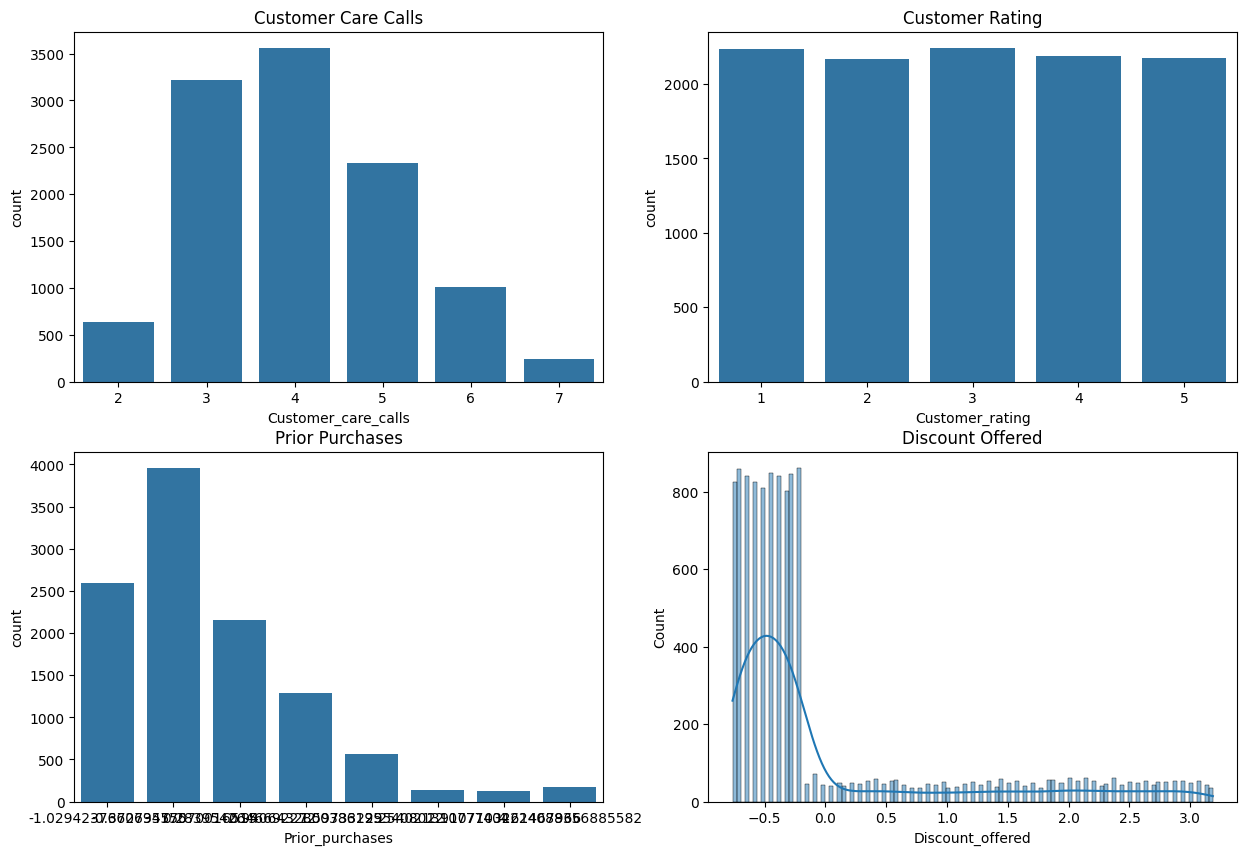

In [470]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.countplot(x = 'Customer_care_calls', data = data, ax=ax[0,0]).set_title('Customer Care Calls')
sns.countplot(x = 'Customer_rating', data = data, ax=ax[0,1]).set_title('Customer Rating')
sns.countplot(x = 'Prior_purchases', data = data, ax=ax[1,0]).set_title('Prior Purchases')
sns.histplot(x = 'Discount_offered', data = data, ax=ax[1,1], kde = True).set_title('Discount Offered')

<h3 style="color:#ADD8E6;">Step 3-4: Gender vs Reached on Time </h3>


Text(0.5, 1.0, 'Gender vs Reached on Time')

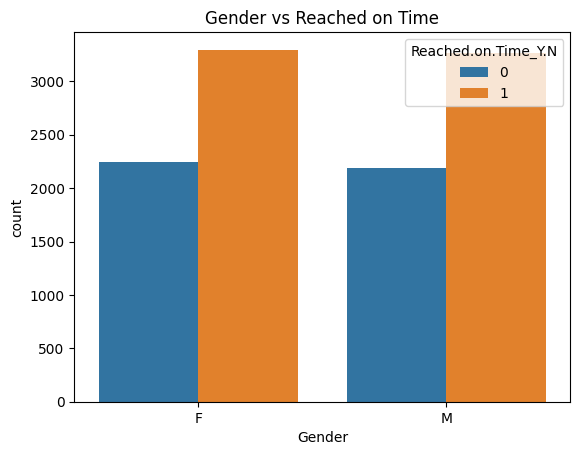

In [444]:
sns.countplot(x = 'Gender', data = data, hue = 'Reached.on.Time_Y.N').set_title('Gender vs Reached on Time')

<h3 style="color:#ADD8E6;">Step 3-5: Warehouse, Shipment Mode, and Timely Delivery Analysis </h3>


Text(0.5, 1.0, 'Reached on Time')

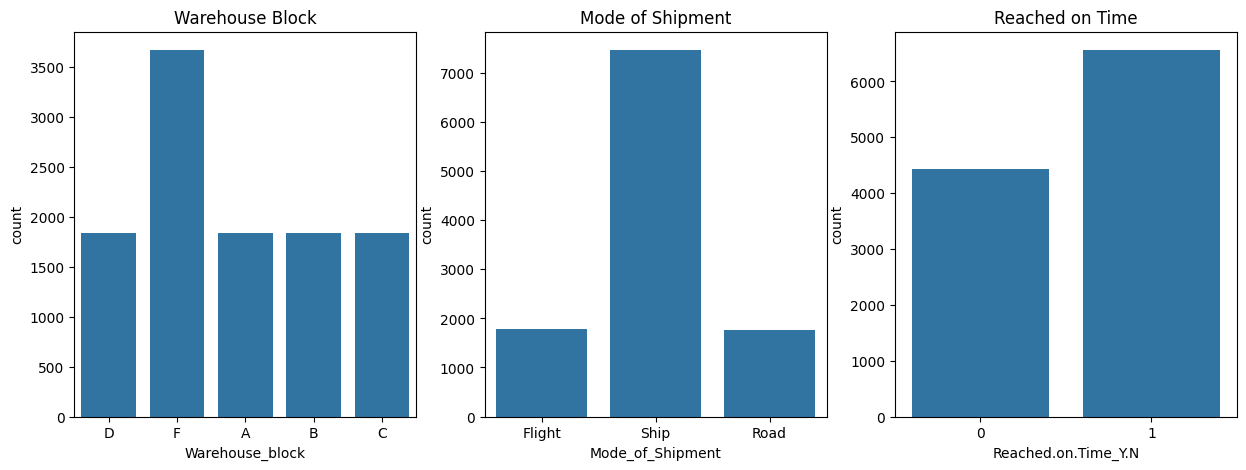

In [52]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x = 'Warehouse_block', data = data, ax=ax[0]).set_title('Warehouse Block')
sns.countplot(x = 'Mode_of_Shipment', data = data, ax=ax[1]).set_title('Mode of Shipment')
sns.countplot(x = 'Reached.on.Time_Y.N', data = data, ax=ax[2]).set_title('Reached on Time')

<h3 style="color:#ADD8E6;">Step 3-6: Warehouse Block and Shipment Mode Analysis with Timely Delivery </h3>


Text(0.5, 1.0, 'Mode of Shipment')

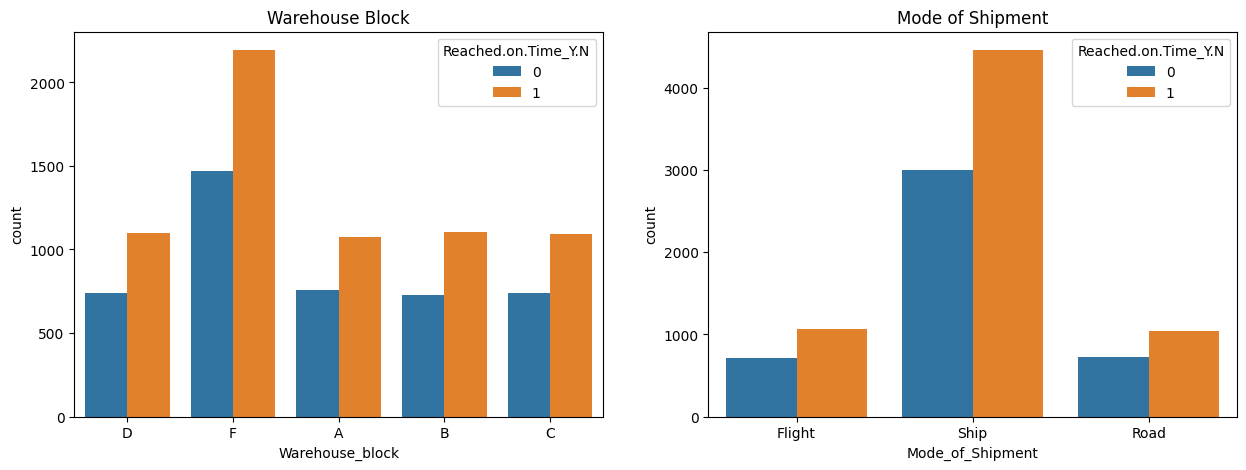

In [53]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x = 'Warehouse_block', data = data, ax=ax[0], hue = 'Reached.on.Time_Y.N').set_title('Warehouse Block')
sns.countplot(x = 'Mode_of_Shipment', data = data, ax=ax[1], hue = 'Reached.on.Time_Y.N').set_title('Mode of Shipment')

<h3 style="color:#ADD8E6;">Step 3-7: Customer Care, Rating, Purchases, and Discount Analysis with Timely Delivery </h3>


Text(0.5, 1.0, 'Discount Offered')

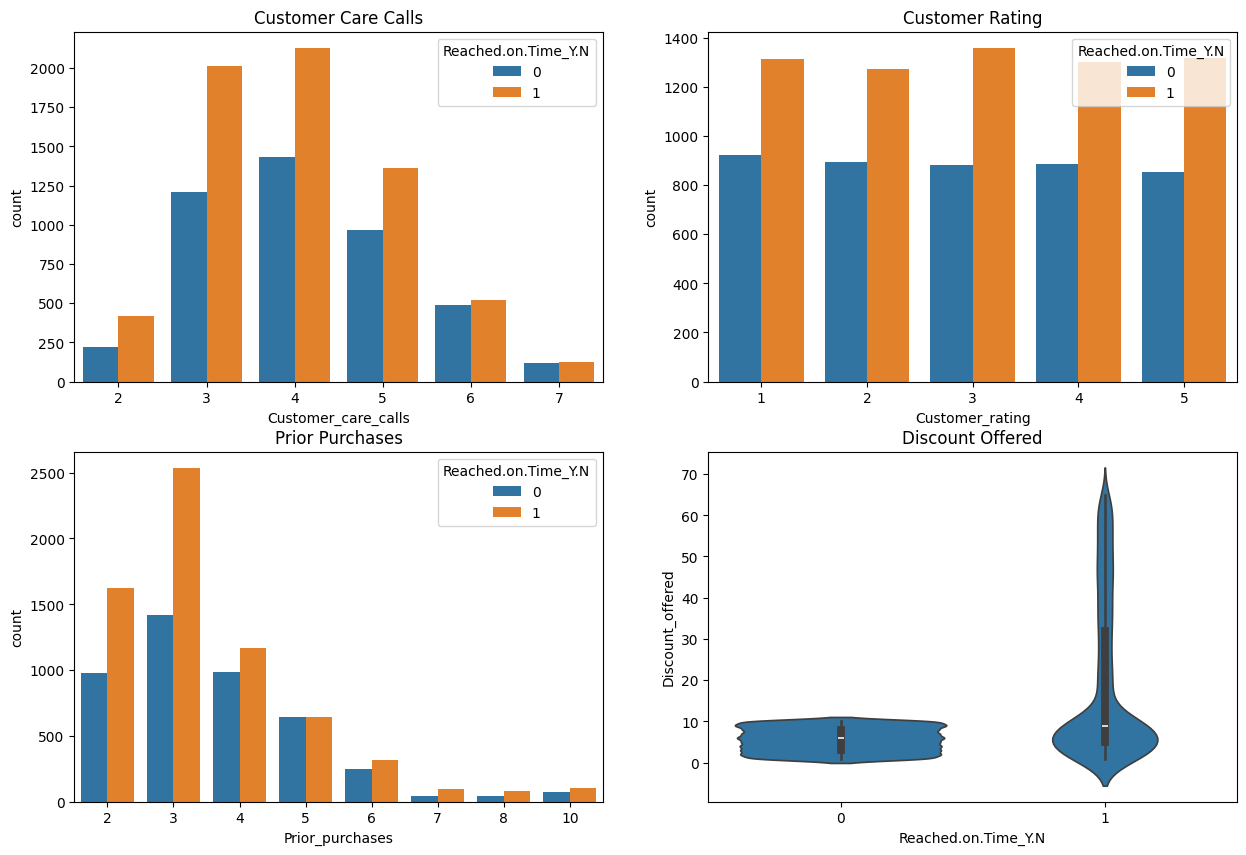

In [54]:

fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.countplot(x = 'Customer_care_calls', data = data, ax=ax[0,0],hue = 'Reached.on.Time_Y.N').set_title('Customer Care Calls')
sns.countplot(x = 'Customer_rating', data = data, ax=ax[0,1],hue = 'Reached.on.Time_Y.N').set_title('Customer Rating')
sns.countplot(x = 'Prior_purchases', data = data, ax=ax[1,0],hue = 'Reached.on.Time_Y.N').set_title('Prior Purchases')
sns.violinplot(x = 'Reached.on.Time_Y.N', y = 'Discount_offered' ,data = data, ax=ax[1,1]).set_title('Discount Offered')

<h3 style="color:#ADD8E6;">Step 3-8: Visualizing Product Cost by Warehouse Block and Delivery Timeliness</h3>


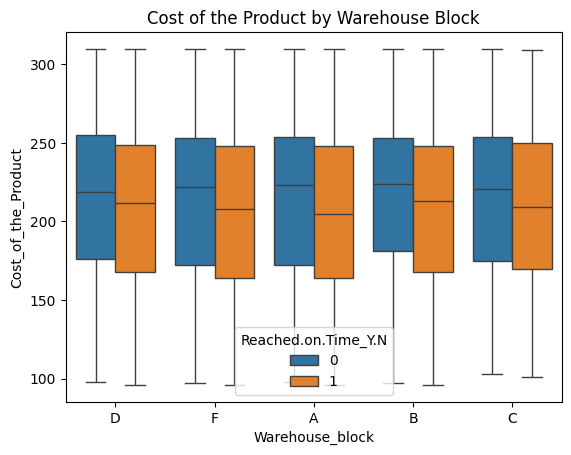

In [55]:
sns.boxplot(x='Warehouse_block', y='Cost_of_the_Product', data=data, hue='Reached.on.Time_Y.N')
plt.title("Cost of the Product by Warehouse Block")
plt.show()

<h3 style="color:#ADD8E6;">Step 3-9: Analyzing Average Product Weight by Warehouse Block and Delivery Timeliness</h3>


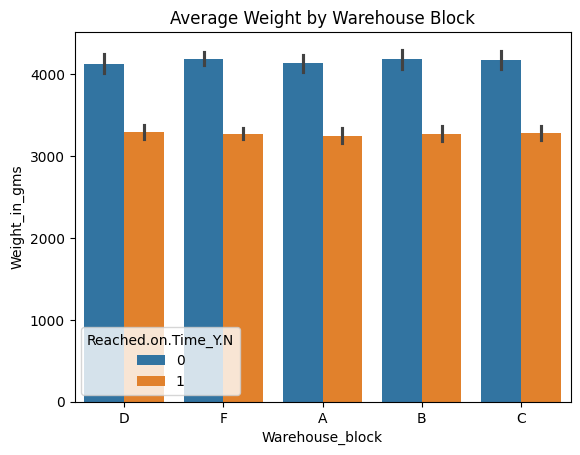

In [56]:
sns.barplot(x='Warehouse_block', y='Weight_in_gms', hue='Reached.on.Time_Y.N', data=data)
plt.title("Average Weight by Warehouse Block")
plt.show()

<h3 style="color:#ADD8E6;">Step 3-10: Shipment Mode Distribution by Delivery Timeliness</h3>


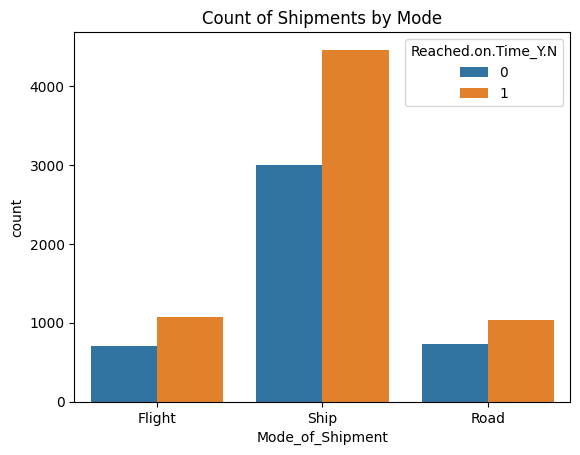

In [57]:
sns.countplot(x='Mode_of_Shipment', hue='Reached.on.Time_Y.N', data=data)
plt.title("Count of Shipments by Mode")
plt.show()

<h3 style="color:#ADD8E6;">Step 3-11: Heatmap </h3>


In [471]:
data = common_fun.all_label_encode(data)

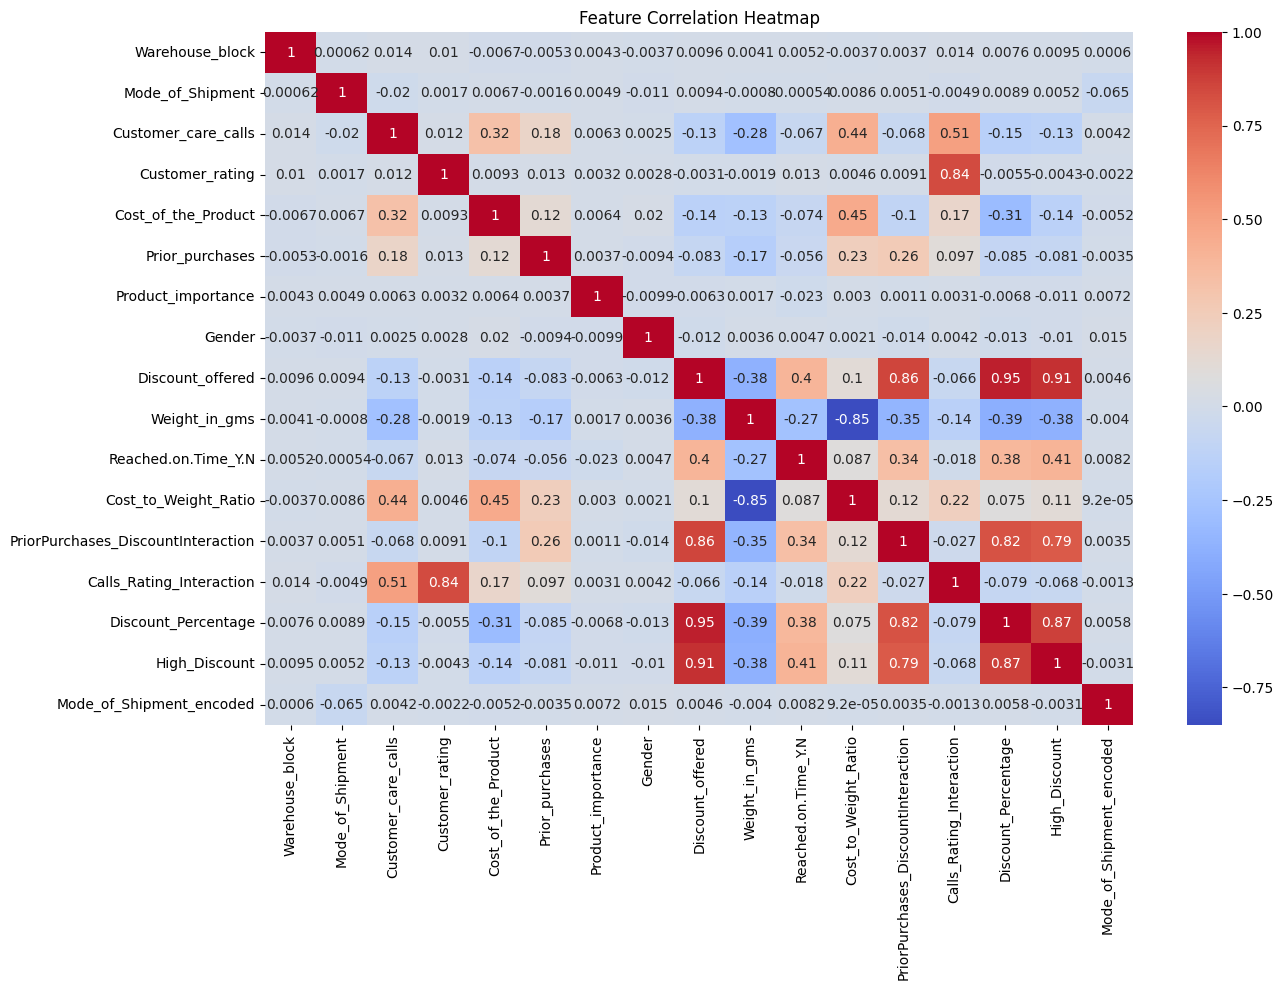

In [472]:
plt.figure(figsize=(14, 9))

sns.heatmap(data.corr(), annot=True, cmap="coolwarm",)
plt.title("Feature Correlation Heatmap")
plt.show()


<h3 style="color:#ADD8E6;">Step 3-12: Cost of Product vs Customer Care Calls </h3>


<Axes: xlabel='Customer_care_calls', ylabel='Cost_of_the_Product'>

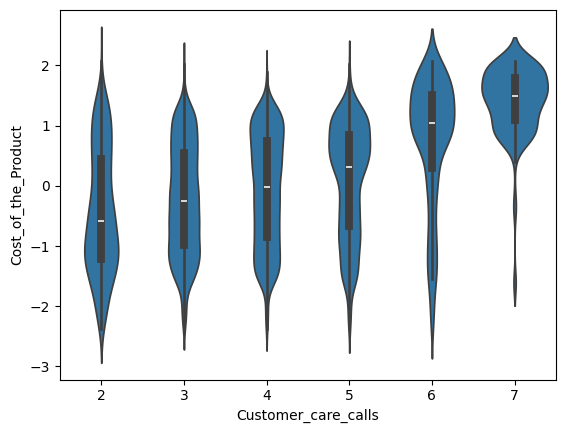

In [473]:
sns.violinplot(x = 'Customer_care_calls', y = 'Cost_of_the_Product', data = data)

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 4 | Train And Evaluate Model </p>


In [474]:
# data = pd.get_dummies(data, columns=['Mode_of_Shipment', 'Warehouse_block'], drop_first=True)
data = common_fun.all_label_encode(data)
data

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Cost_to_Weight_Ratio,PriorPurchases_DiscountInteraction,Calls_Rating_Interaction,Discount_Percentage,High_Discount,Mode_of_Shipment_encoded
0,3,0,4,2,-0.690722,-0.372735,1,0,1.889983,-1.468240,1,0.143552,132,8,24.858757,1,0.601576
1,4,0,4,5,0.120746,-1.029424,1,1,2.815636,-0.333893,1,0.069948,118,20,27.314815,1,0.601576
2,0,0,2,2,-0.565881,0.283954,1,1,2.136824,-0.159002,1,0.054238,192,4,26.229508,1,0.601576
3,1,0,3,3,-0.711529,0.283954,2,1,-0.208162,-1.502484,1,0.149533,40,9,5.681818,0,0.601576
4,2,0,2,2,-0.545074,-0.372735,2,0,2.013404,-0.703244,1,0.074074,138,4,25.000000,1,0.601576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,0,2,4,1,0.869792,0.940643,2,0,-0.763553,-1.281730,1,0.163849,5,4,0.396825,0,0.597561
10995,1,2,4,1,0.453655,0.940643,2,0,-0.455002,-1.459679,0,0.186047,30,4,2.586207,0,0.597561
10996,2,2,5,4,0.661724,0.940643,1,0,-0.578423,-1.515937,0,0.209524,20,20,1.652893,0,0.597561
10997,4,2,5,2,0.266394,1.597332,2,1,-0.701843,-1.482304,0,0.184298,12,10,0.896861,0,0.597561


<h3 style="color:#ADD8E6;">Step 4-1: Separating Features and Target for Model Training</h3>


In [475]:
X = data.drop(columns=['Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

<h3 style="color:#ADD8E6;">Step 4-2: Split the dataset into training and testing sets</h3>


In [476]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3 style="color:#ADD8E6;">Step 4-3: GridSearchCV for Hyperparameter Tuning Across Multiple Models </h3>


In [477]:
model_params = {
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [10, 50, 100],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"],
            "max_iter": [100, 200],
        },
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "criterion": ["gini", "entropy"],
        },
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2],
        },
    },
}

results = {}
for model_name, mp in model_params.items():
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring="accuracy", n_jobs=1)
    grid.fit(X_train, y_train)

    results[model_name] = {
        "best_params": grid.best_params_,
        "best_score": grid.best_score_,
    }

    print(f"\n{model_name} Best Parameters: {grid.best_params_}")
    print(f"{model_name} Best Cross-Validation Score: {grid.best_score_:.4f}")


RandomForestClassifier Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
RandomForestClassifier Best Cross-Validation Score: 0.6774


c:\Users\jay\anaconda3\envs\jay\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jay\anaconda3\envs\jay\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres


LogisticRegression Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
LogisticRegression Best Cross-Validation Score: 0.6538

DecisionTreeClassifier Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
DecisionTreeClassifier Best Cross-Validation Score: 0.6709

KNeighborsClassifier Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
KNeighborsClassifier Best Cross-Validation Score: 0.6350


<h3 style="color:#ADD8E6;">Step 4-4: Summary of Best Parameters and Cross-Validation Scores for Models</h3>


In [478]:
results

{'RandomForestClassifier': {'best_params': {'max_depth': 10,
   'min_samples_split': 2,
   'n_estimators': 50},
  'best_score': 0.6773513489069203},
 'LogisticRegression': {'best_params': {'C': 10,
   'max_iter': 100,
   'solver': 'liblinear'},
  'best_score': 0.6538258437128533},
 'DecisionTreeClassifier': {'best_params': {'criterion': 'entropy',
   'max_depth': 10,
   'min_samples_split': 10},
  'best_score': 0.670872977931676},
 'KNeighborsClassifier': {'best_params': {'n_neighbors': 7,
   'p': 1,
   'weights': 'uniform'},
  'best_score': 0.6349602692645615}}

In [479]:
print("\nSummary of GridSearchCV Results:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Best CV Score: {result['best_score']:.4f}")


Summary of GridSearchCV Results:
RandomForestClassifier:
  Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
  Best CV Score: 0.6774
LogisticRegression:
  Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
  Best CV Score: 0.6538
DecisionTreeClassifier:
  Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
  Best CV Score: 0.6709
KNeighborsClassifier:
  Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
  Best CV Score: 0.6350


<h3 style="color:#ADD8E6;">Step 4-5: Extracting and Accessing Best Parameters from GridSearchCV Results </h3>


In [480]:
best_params_list = []
for model_name, result in results.items():
    best_params_list.append(result["best_params"])

<h3 style="color:#ADD8E6;">Step 4-6: Instantiating Models with Best Parameters and Evaluating Their Performance</h3>


In [481]:
rf = RandomForestClassifier(**best_params_list[0])
lr = LogisticRegression(**best_params_list[1])
dt = DecisionTreeClassifier(**best_params_list[2])
kn = KNeighborsClassifier(**best_params_list[3])

models = [
    rf,
    lr,
    DecisionTreeClassifier(**best_params_list[2]),
    KNeighborsClassifier(**best_params_list[3]),
]

results_reg,all_predictions  = train_and_evaluate_multiple_models(models, X_train, X_test, y_train, y_test,return_y_pred=True)

Model: RandomForestClassifier (Classifier) -> Accuracy: 0.6895454545454546
Model: LogisticRegression (Classifier) -> Accuracy: 0.6609090909090909
Model: DecisionTreeClassifier (Classifier) -> Accuracy: 0.6686363636363636
Model: KNeighborsClassifier (Classifier) -> Accuracy: 0.6163636363636363


<h3 style="color:#ADD8E6;">Step 4-7: Random Forest Hyperparameter Tuning Using GridSearchCV</h3>


In [391]:
RFmodel = RandomForestClassifier()
param_grid = {
    'max_depth': [4,8,12,16],
    'min_samples_leaf': [2,4,6,8],
    'min_samples_split': [2,4,6],
    'criterion': ['gini', 'entropy'],
}

grid_search = GridSearchCV(
    estimator=RFmodel,  
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  
)

<h3 style="color:#ADD8E6;">Step 4-8: Hyperparameter Tuning with GridSearchCV to Find the Best Model Parameters</h3>


In [392]:
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [393]:
print(best_params)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 6}


<h3 style="color:#ADD8E6;">Step 4-9: Training and Evaluating a Random Forest Classifier with Optimized Hyperparameters</h3>


In [394]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_features = importance_df.head(10)['Feature'].tolist()
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [395]:
RFmodel = RandomForestClassifier(random_state=42,**best_params)

RFmodel.fit(X_train, y_train)

y_pred = RFmodel.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6872727272727273
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       895
           1       0.92      0.52      0.66      1305

    accuracy                           0.69      2200
   macro avg       0.74      0.73      0.69      2200
weighted avg       0.78      0.69      0.68      2200



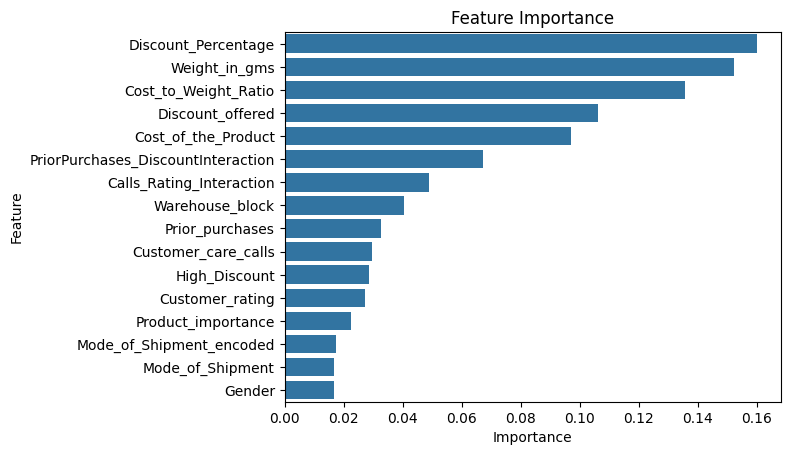

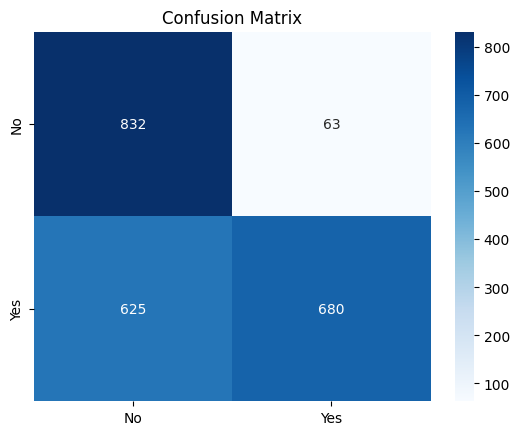

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
plt.title("Feature Importance")
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.show()

<h3 style="color:#ADD8E6;">Step 4-10: Comprehensive Classification Model Evaluation Function with Metrics and Visualization</h3>


In [397]:
def evaluate_model(model, x_test, y_test, model_name):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Check if the model has predict_proba
    if hasattr(model, "predict_proba"):
        auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    else:
        auc = "N/A"  # or you can set it to None if you prefer

    print("--- {model_name} Evaluation ---")
    print("Accuracy: {accuracy:.4f}")
    print("ROC-AUC: {auc if isinstance(auc, str) else auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score'],
        "AUC-ROC": auc
    }

<h3 style="color:#ADD8E6;">Step 4-11: Comparative Evaluation of Classifier Models</h3>


--- {model_name} Evaluation ---
Accuracy: {accuracy:.4f}
ROC-AUC: {auc if isinstance(auc, str) else auc:.4f}
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      3541
           1       0.71      0.68      0.69      5258

    accuracy                           0.64      8799
   macro avg       0.63      0.63      0.63      8799
weighted avg       0.65      0.64      0.64      8799



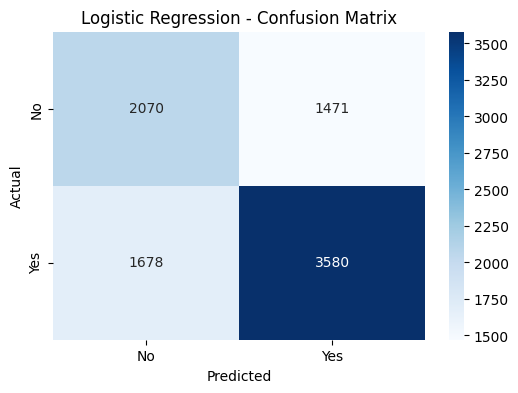

--- {model_name} Evaluation ---
Accuracy: {accuracy:.4f}
ROC-AUC: {auc if isinstance(auc, str) else auc:.4f}
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       895
           1       0.92      0.52      0.67      1305

    accuracy                           0.69      2200
   macro avg       0.74      0.73      0.69      2200
weighted avg       0.78      0.69      0.68      2200



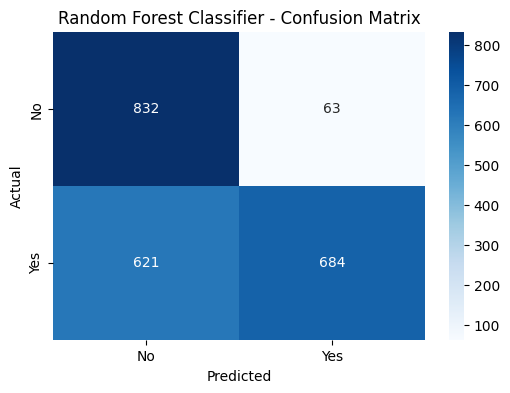

In [36]:
results = []

# Evaluate Logistic Regression
logreg_best = lr
results.append(evaluate_model(logreg_best, X_train, y_train, "Logistic Regression"))

# Evaluate Random Forest
rf_best = RFmodel
results.append(evaluate_model(rf_best, X_test, y_test, "Random Forest Classifier"))

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 5 | Model Save </p>


In [37]:
dump(RFmodel, 'random_forest_model.joblib')

['random_forest_model.joblib']